# Assistant Sensitivity Analysis

In [1]:
import os
import sys

os.chdir("../")
sys.path.append("../../")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mirrorbench.io.paths import Paths
from mirrorbench.report import generate_json_report

In [3]:
def get_report_for_run(run_id: str):
    paths = Paths.default()
    summary = paths.load_run_summary(run_id)
    report = generate_json_report(summary)
    return report

def get_run_metric_list(run_id: str, metric_name: str):
    report = get_report_for_run(run_id)
    mean_list = []
    ci_list = []
    for agg in report["aggregates"]:
        if agg["metric_name"] == metric_name:
            mean_list.append(agg["mean"])
            ci_list.append(agg["confidence_interval"])
    return mean_list, ci_list

In [4]:
run_id_temp = "chatbot_arena_mirror-{user_model}-user-{assistant_model}-assistant-claude-4-sonnet-judge"

user_models = [
    "gpt-4o",
    "gpt-5",
    "gpt-oss-120b",
    "claude-4-sonnet",
    "gemini-2.5-pro"
]
assistant_models = [
    "gpt-4o",
    "claude-4-sonnet",
    "gemini-2.5-pro"
]
metric_to_key = {
    "metric:judge/gteval": "GTEval (↑)",
    'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',
    'metric:judge/rubric_and_reason': 'RNR (↑)'
}
proxy_to_metric_map = {
    user: {} for user in user_models
}
for user_model in user_models:
    for assistant_model in assistant_models:
        run_id = run_id_temp.format(
            user_model=user_model,
            assistant_model=assistant_model
        )
        proxy_to_metric_map[user_model][assistant_model] = {}
        for metric_name, key in metric_to_key.items():
            mean_list, ci_list = get_run_metric_list(run_id=run_id, metric_name=metric_name)
            proxy_to_metric_map[user_model][assistant_model][key] = {
                "mean": mean_list[0],
                "ci": ci_list[0]
            }

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2014/995905234.py:17: SyntaxWarning: invalid escape sequence '\D'
  'metric:judge/pi_pairwise': 'PI $\Delta w$ (↑)',


In [5]:
proxy_to_metric_map

{'gpt-4o': {'gpt-4o': {'GTEval (↑)': {'mean': 0.5538461538461539,
    'ci': 0.042015783231297746},
   'PI $\\Delta w$ (↑)': {'mean': 0.49914529914529915,
    'ci': 0.057176744904434876},
   'RNR (↑)': {'mean': 0.8564102564102564, 'ci': 0.049345762701837215}},
  'claude-4-sonnet': {'GTEval (↑)': {'mean': 0.5605128205128205,
    'ci': 0.04241428278703519},
   'PI $\\Delta w$ (↑)': {'mean': 0.5555555555555556,
    'ci': 0.05440457280333978},
   'RNR (↑)': {'mean': 0.8666666666666667, 'ci': 0.04783465444445164}},
  'gemini-2.5-pro': {'GTEval (↑)': {'mean': 0.5715384615384616,
    'ci': 0.04177330689230692},
   'PI $\\Delta w$ (↑)': {'mean': 0.5598290598290598,
    'ci': 0.055164995831289615},
   'RNR (↑)': {'mean': 0.8769230769230769, 'ci': 0.046229190711676416}}},
 'gpt-5': {'gpt-4o': {'GTEval (↑)': {'mean': 0.28923076923076924,
    'ci': 0.0326412680090286},
   'PI $\\Delta w$ (↑)': {'mean': 0.5687285223367697,
    'ci': 0.05747261668176353},
   'RNR (↑)': {'mean': 0.7422680412371134, 'c

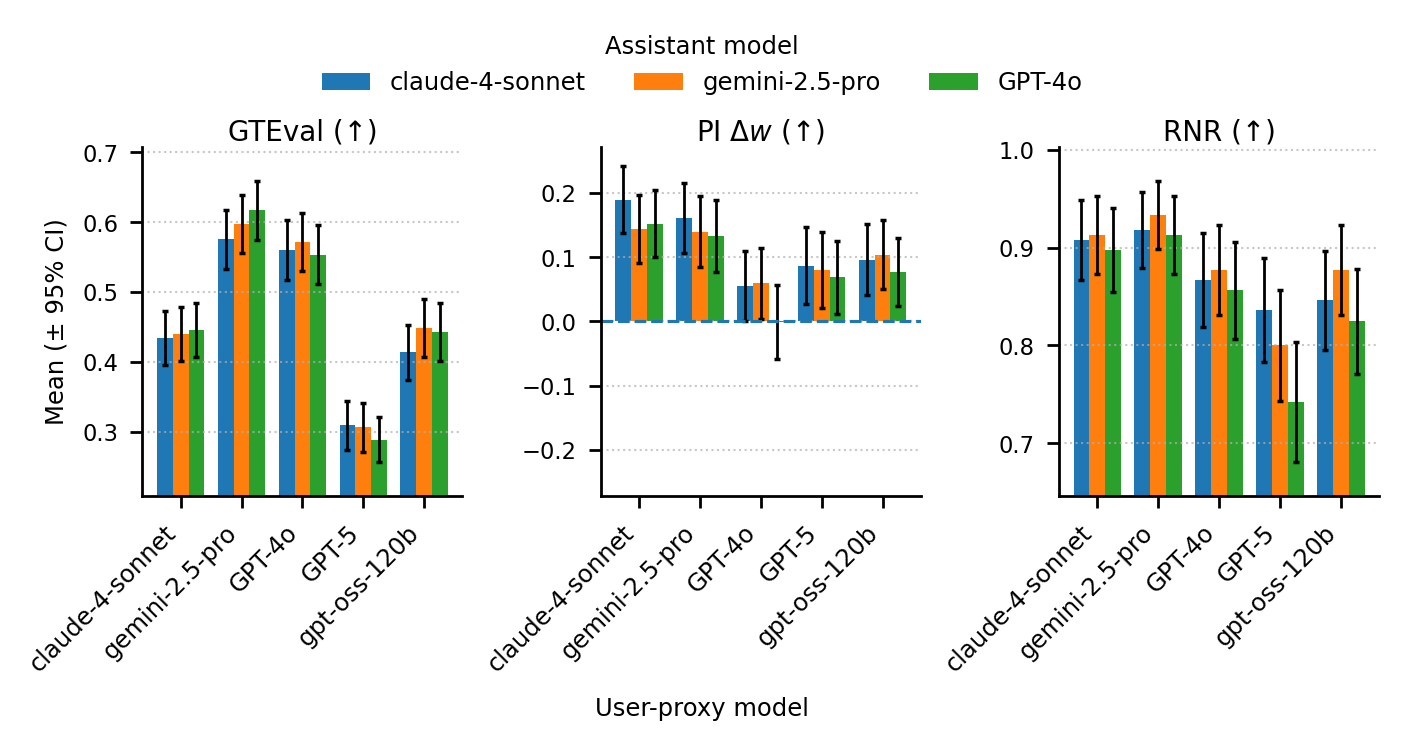

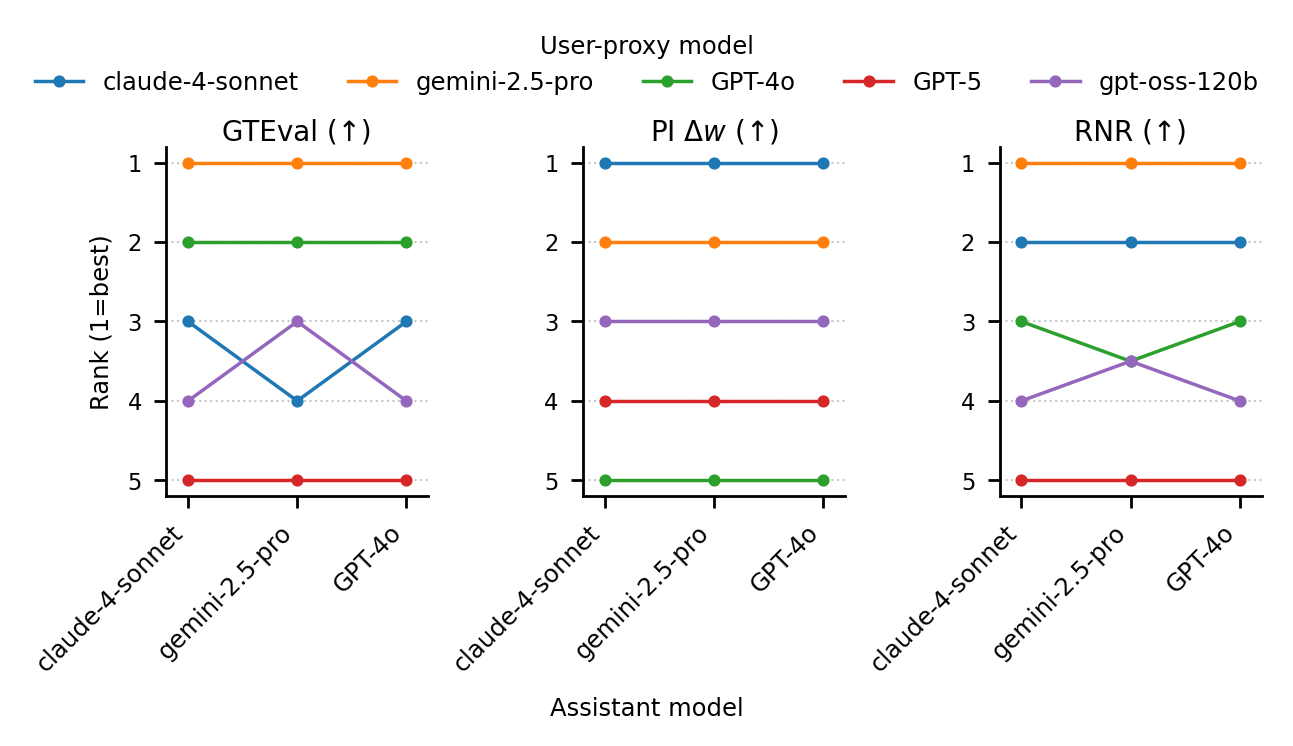

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# results: dict = {user_proxy: {assistant: {metric: {mean, ci}}}}
# (paste your results dict here)
results = proxy_to_metric_map

METRICS = ["GTEval (↑)", "PI $\\Delta w$ (↑)", "RNR (↑)"]
DISPLAY = {
    "claude-4-sonnet": "claude-4-sonnet",
    "gemini-2.5-pro": "gemini-2.5-pro",
    "gpt-4o": "GPT-4o",
    "gpt-5": "GPT-5",
    "gpt-oss-120b": "gpt-oss-120b",
}
ASSISTANTS = ["claude-4-sonnet", "gemini-2.5-pro", "gpt-4o"]
PROXIES   = ["claude-4-sonnet", "gemini-2.5-pro", "gpt-4o", "gpt-5", "gpt-oss-120b"]

def disp(x): 
    return DISPLAY.get(x, x)

def adjust_mean(metric, mean_value):
    # For PI: plot Δw = PI - 0.5
    if "PI" in metric:
        return mean_value - 0.5
    return mean_value

def extract(proxy, assistant, metric):
    d = results[proxy][assistant][metric]
    return adjust_mean(metric, d["mean"]), d["ci"]

# -------------------------
# Plot 1: grouped bars 1x3
# -------------------------
fig1, axes = plt.subplots(1, 3, figsize=(5.5, 2.5), dpi=250, constrained_layout=True)
x = np.arange(len(PROXIES))
width = 0.26
offsets = (np.arange(len(ASSISTANTS)) - (len(ASSISTANTS) - 1) / 2) * width

for k, metric in enumerate(METRICS):
    ax = axes[k]
    lows, highs = [], []
    for j, a in enumerate(ASSISTANTS):
        means = np.array([extract(p, a, metric)[0] for p in PROXIES], dtype=float)
        cis   = np.array([extract(p, a, metric)[1] for p in PROXIES], dtype=float)
        ax.bar(x + offsets[j], means, width, yerr=cis, capsize=1.0, 
               error_kw={'elinewidth': 0.8}, label=disp(a))
        lows.extend((means - cis).tolist())
        highs.extend((means + cis).tolist())

    ax.set_title(metric, fontsize=8, pad=2)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.6, alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks(x)
    ax.set_xticklabels([disp(p) for p in PROXIES], rotation=45, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=6.5)

    if "PI" in metric:
        ax.axhline(0, linestyle="--", linewidth=0.9)
        y_min, y_max = float(min(lows)), float(max(highs))
        max_abs = max(abs(y_min), abs(y_max))
        ax.set_ylim(-(max_abs + 0.03), (max_abs + 0.03))
    else:
        y_min, y_max = float(min(lows)), float(max(highs))
        rng = y_max - y_min
        pad = 0.12 * rng if rng > 0 else 0.05
        ax.set_ylim(y_min - pad, y_max + pad)

axes[0].set_ylabel("Mean (± 95% CI)", fontsize=7)
fig1.supxlabel("User-proxy model", fontsize=7)

handles, labels = axes[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc="upper center", ncol=3, frameon=False,
            title="Assistant model", bbox_to_anchor=(0.5, 1.15),
            fontsize=7, title_fontsize=7)

# fig1.savefig("assistant_sensitivity_1x3_singlecol_clean.png", bbox_inches="tight")
fig1.savefig(
    "assistant_sensitivity_1x3_singlecol_clean.pdf",
    bbox_inches="tight",
    format='pdf'
)
plt.show()

# -------------------------
# Plot 2: rank lines 1x3 (with legend)
# -------------------------
def ranks_from_scores(scores):
    order = np.argsort(-scores)
    ranks = np.empty_like(scores, dtype=float)
    ranks[order] = np.arange(1, len(scores) + 1)

    # average ties
    uniq = {}
    for i, s in enumerate(scores):
        uniq.setdefault(s, []).append(i)
    for s, idxs in uniq.items():
        if len(idxs) > 1:
            ranks[idxs] = float(np.mean(ranks[idxs]))
    return ranks

from matplotlib import patheffects

fig2, axes = plt.subplots(1, 3, figsize=(5.0, 2.5), dpi=250, constrained_layout=True)
xa = np.arange(len(ASSISTANTS))

for k, metric in enumerate(METRICS):
    ax = axes[k]
    score_mat = np.zeros((len(PROXIES), len(ASSISTANTS)), dtype=float)
    for i, p in enumerate(PROXIES):
        for j, a in enumerate(ASSISTANTS):
            score_mat[i, j] = extract(p, a, metric)[0]

    ranks_mat = np.zeros_like(score_mat)
    for j in range(len(ASSISTANTS)):
        ranks_mat[:, j] = ranks_from_scores(score_mat[:, j])
    
    # Plot lines with legend labels
    for i, p in enumerate(PROXIES):
        ax.plot(xa, ranks_mat[i, :], marker="o", linewidth=1.0, markersize=2.5, label=disp(p))

    ax.set_title(metric, fontsize=8, pad=2)
    ax.grid(True, axis="y", linestyle=":", linewidth=0.6, alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks(xa)
    ax.set_xticklabels([disp(a) for a in ASSISTANTS], rotation=45, ha="right", fontsize=7)
    ax.tick_params(axis="y", labelsize=6.5)

    ax.invert_yaxis()
    ax.set_yticks(np.arange(1, len(PROXIES) + 1))
    ax.set_xlim(-0.2, xa[-1] + 0.2)

axes[0].set_ylabel("Rank (1=best)", fontsize=7)
fig2.supxlabel("Assistant model", fontsize=7)

# Add legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig2.legend(handles, labels, loc="upper center", ncol=5, frameon=False,
            title="User-proxy model", bbox_to_anchor=(0.5, 1.15),
            fontsize=7, title_fontsize=7)

# fig2.savefig("assistant_rank_lines_1x3_singlecol_clean.png", bbox_inches="tight")
fig2.savefig(
    "assistant_rank_stability_1x3_singlecol_clean.pdf",
    bbox_inches="tight",
    format="pdf"
)
plt.show()
